OCR Numbers Detection Code (using Google Colab)

Installing required libraries and dependencies

In [1]:
!pip install opencv-python opencv-python-headless easyocr pandas scikit-learn numpy regex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96

**Using through Easy OCR pipeline**

For **Image 01** DATA: VW_DTN01_L_00007_101000000000000000002038853600000.front.JPG



In [2]:
import cv2
import easyocr
import re
import pandas as pd
from google.colab.patches import cv2_imshow

In [3]:
# =============================================
# Preprocessing
# =============================================
def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error: Could not load image.")

    return image

In [4]:
# =============================================
# Model Inference
# =============================================
def run_ocr(image):
    """Run OCR using EasyOCR with custom parameters."""
    reader = easyocr.Reader(['en'], gpu=False)

    results = reader.readtext(
        image,
        allowlist="0123456789.",  # Restrict detection to numbers and decimals
        width_ths=0.3,            # Merge closer text regions
        text_threshold=0.4,       # Lower threshold for faint text
        link_threshold=0.4        # Adjust for connected characters
    )

    return results

In [5]:
# =============================================
# Post-processing
# =============================================
def process_results(results, image, image_path, output_csv="output.csv"):
    """Filter and save extracted numbers along with annotated image."""
    image_name = image_path.split('/')[-1]
    valid_numbers = []

    for bbox, text, confidence in results:
        if re.match(r'^-?\d+\.?\d*$', text) and confidence > 0.3:
            (x_min, y_min), _, (x_max, y_max), _ = bbox
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

            valid_numbers.append(text)

            # Draw bounding boxes
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, text, (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 0), 1)

    # Save results to CSV
    df = pd.DataFrame({
        "Image Name": [image_name],
        "Extracted Numbers": [", ".join([f'"{num}"' for num in valid_numbers])]
    })
    df.to_csv(output_csv, index=False)

    # Show annotated image
    cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    print(f"Detected {len(valid_numbers)} valid numbers. CSV saved to {output_csv}")


In [6]:
# =============================================
# Main Function
# =============================================
def process_image(image_path, output_csv="/content/output_img01_1.csv"):
    """Pipeline: Preprocessing -> Model Inference -> Post-processing"""
    image = preprocess_image(image_path)
    results = run_ocr(image)
    process_results(results, image, image_path, output_csv)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

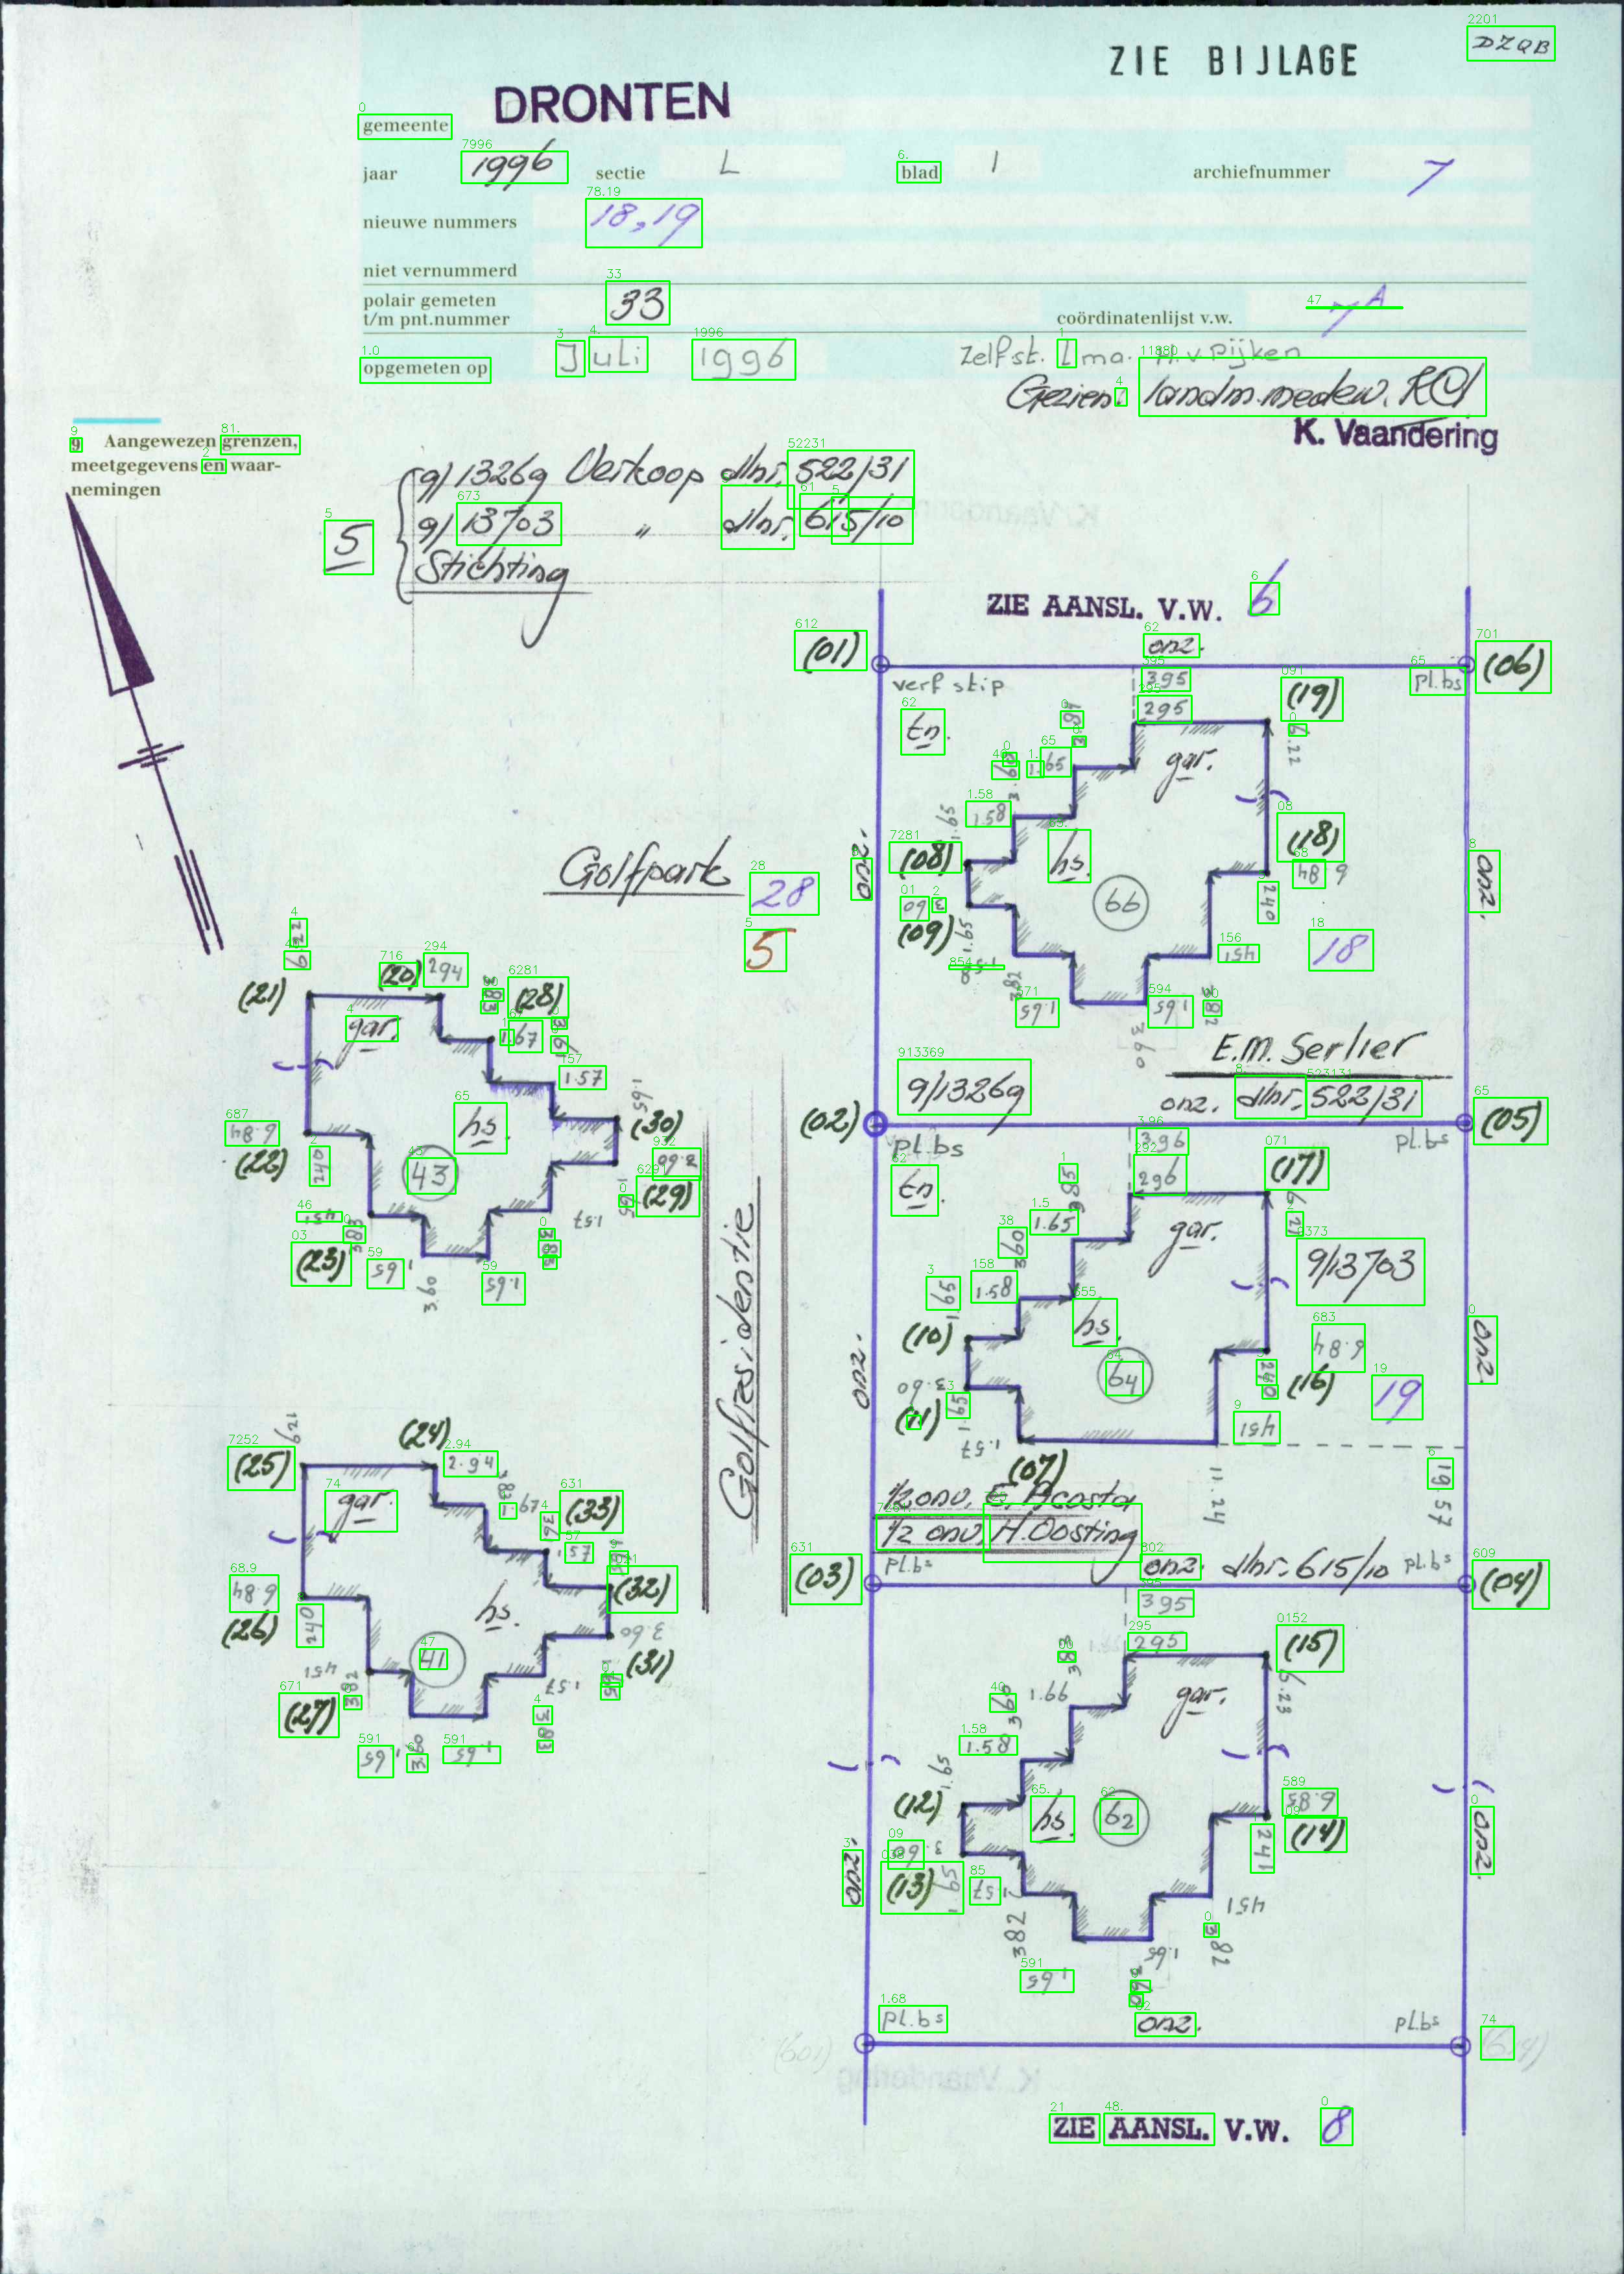

Detected 163 valid numbers. CSV saved to /content/output_img01_1.csv


In [7]:
process_image("/content/VW_DTN01_L_00007_101000000000000000002038853600000.front.JPG", "/content/output_img01_1.csv")

**Using EASY OCR with the Model**

For **Image01** DATA: VW_DTN01_L_00007_101000000000000000002038853600000.front.JPG

In [8]:
import cv2
import easyocr
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab.patches import cv2_imshow

In [9]:
# =============================================
# Preprocessing
# =============================================

def preprocess_image(image_path):
    """
    Preprocess the image for OCR.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return image, thresh  # Return both original and preprocessed image

In [10]:
# =============================================
# Model Training/Inference (with RandomForest)
# =============================================

def train_model(X, y):
    """
    Train a simple model for classification (example).
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    return model

In [11]:
def extract_features(image):
    """
    Extract features from the image for training/inference.
    """
    #histogram of oriented gradients (HOG) features
    hog = cv2.HOGDescriptor()
    features = hog.compute(image)
    return features.flatten()


In [12]:
# =============================================
# OCR and Post-Processing
# =============================================

def perform_ocr(image):
    """
    Perform OCR on the preprocessed image.
    """
    reader = easyocr.Reader(['en'], gpu=False)
    results = reader.readtext(
        image,
        allowlist="0123456789.",  # Restrict to numbers and decimals
        width_ths=0.3,            # Merge closer text regions
        text_threshold=0.4,       # Lower threshold for faint text
        link_threshold=0.4        # Adjust for connected characters
    )
    return results

In [13]:
def post_process_results(results, image):
    """
    Post-process OCR results and draw bounding boxes on the image.
    """
    valid_numbers = []
    for bbox, text, confidence in results:
        # Regex validation for numbers/decimals
        if re.match(r'^-?\d+\.?\d*$', text) and confidence > 0.3:
            # Extract bounding box coordinates
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))

            # Draw bounding box on the image
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green box
            cv2.putText(image, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 0), 2)  # Text label

            valid_numbers.append(text)
    return valid_numbers, image


In [15]:
# =============================================
# Main Pipeline
# =============================================

def ocr_pipeline(image_path, output_csv="/content/output_img01_2.csv"):
    """
    Full OCR pipeline: Preprocessing -> OCR -> Post-processing.
    """
    original_image, preprocessed_image = preprocess_image(image_path)

    ocr_results = perform_ocr(preprocessed_image)

    valid_numbers, output_image = post_process_results(ocr_results, original_image)

    image_name = image_path.split('/')[-1]
    data = {
        "Image Name": [image_name],
        "Extracted Numbers": [", ".join([f'"{num}"' for num in valid_numbers])]
    }
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)

    cv2_imshow(output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image with bounding boxes
    output_image_path = image_path.replace(".JPG", "_output.JPG")
    cv2.imwrite(output_image_path, output_image)

    print(f"Detected {len(valid_numbers)} valid numbers. CSV saved to {output_csv}")
    print(f"Output image with bounding boxes saved to {output_image_path}")

In [ ]:
if __name__ == "__main__":

    image_path = "/content/VW_DTN01_L_00007_101000000000000000002038853600000.front.JPG"

    # Run the OCR pipeline
    ocr_pipeline(image_path)

Now,
**Using through Easy OCR pipeline**

For **Image02** DATA: VW_DTN01_A_00002_101000000000000000002051033000000.front.JPG

In [ ]:
# =============================================
# Preprocessing
# =============================================
def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error: Could not load image.")

    return image

# =============================================
# Model Inference
# =============================================
def run_ocr(image):
    """Run OCR using EasyOCR with custom parameters."""
    reader = easyocr.Reader(['en'], gpu=False)

    results = reader.readtext(
        image,
        allowlist="0123456789.",  # Restrict detection to numbers and decimals
        width_ths=0.3,            # Merge closer text regions
        text_threshold=0.4,       # Lower threshold for faint text
        link_threshold=0.4        # Adjust for connected characters
    )

    return results

# =============================================
# Post-processing
# =============================================
def process_results(results, image, image_path, output_csv="output.csv"):
    """Filter and save extracted numbers along with annotated image."""
    image_name = image_path.split('/')[-1]
    valid_numbers = []

    for bbox, text, confidence in results:
        if re.match(r'^-?\d+\.?\d*$', text) and confidence > 0.3:
            (x_min, y_min), _, (x_max, y_max), _ = bbox
            x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])

            valid_numbers.append(text)

            # Draw bounding boxes
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, text, (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 200, 0), 1)

    # Save results to CSV
    df = pd.DataFrame({
        "Image Name": [image_name],
        "Extracted Numbers": [", ".join([f'"{num}"' for num in valid_numbers])]
    })
    df.to_csv(output_csv, index=False)

    # Show annotated image
    cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    print(f"Detected {len(valid_numbers)} valid numbers. CSV saved to {output_csv}")

# =============================================
# Main Function
# =============================================
def process_image(image_path, output_csv="/content/output_img02_1.csv"):
    """Pipeline: Preprocessing -> Model Inference -> Post-processing"""
    image = preprocess_image(image_path)
    results = run_ocr(image)
    process_results(results, image, image_path, output_csv)

process_image("/content/VW_DTN01_A_00002_101000000000000000002051033000000.front.JPG", "/content/output_img02_1.csv")

Using EASY OCR with the Model

For **Image 02** DATA:VW_DTN01_A_00002_101000000000000000002051033000000.front.JPG

In [ ]:
# =============================================
# Preprocessing
# =============================================

def preprocess_image(image_path):
    """
    Preprocess the image for OCR.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return image, thresh  # Return both original and preprocessed image

# =============================================
# Model Training/Inference (with RandomForest)
# =============================================

def train_model(X, y):
    """
    Train a simple model for classification (example).
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy:.2f}")

    return model

def extract_features(image):
    """
    Extract features from the image for training/inference.
    """
    #histogram of oriented gradients (HOG) features
    hog = cv2.HOGDescriptor()
    features = hog.compute(image)
    return features.flatten()

# =============================================
# OCR and Post-Processing
# =============================================

def perform_ocr(image):
    """
    Perform OCR on the preprocessed image.
    """
    reader = easyocr.Reader(['en'], gpu=False)
    results = reader.readtext(
        image,
        allowlist="0123456789.",  # Restrict to numbers and decimals
        width_ths=0.3,            # Merge closer text regions
        text_threshold=0.4,       # Lower threshold for faint text
        link_threshold=0.4        # Adjust for connected characters
    )
    return results

# =============================================
# Main Pipeline
# =============================================

def ocr_pipeline(image_path, output_csv="/content/output_img02_2.csv"):
    """
    Full OCR pipeline: Preprocessing -> OCR -> Post-processing.
    """
    original_image, preprocessed_image = preprocess_image(image_path)

    ocr_results = perform_ocr(preprocessed_image)

    valid_numbers, output_image = post_process_results(ocr_results, original_image)

    image_name = image_path.split('/')[-1]
    data = {
        "Image Name": [image_name],
        "Extracted Numbers": [", ".join([f'"{num}"' for num in valid_numbers])]
    }
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)

    cv2_imshow(output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image with bounding boxes
    output_image_path = image_path.replace(".JPG", "_output.JPG")
    cv2.imwrite(output_image_path, output_image)

    print(f"Detected {len(valid_numbers)} valid numbers. CSV saved to {output_csv}")
    print(f"Output image with bounding boxes saved to {output_image_path}")

if __name__ == "__main__":

    image_path = "/content/VW_DTN01_A_00002_101000000000000000002051033000000.front.JPG"

    # Run the OCR pipeline
    ocr_pipeline(image_path)

Here, through Using EASY OCR Pipeline method, we are able to detect more text (numbers), so considering output_img_01_1.csv and output_img02_1.csv for the final csv output.

**Combining the csv files**

In [20]:
import pandas as pd

csv1 = pd.read_csv('/content/output_img01_1.csv')
csv2 = pd.read_csv('/content/output_img02_1.csv')

combined_csv = pd.concat([csv1, csv2], ignore_index=True)

combined_csv.to_csv('/content/output_ocr.csv', index=False)

print("CSV files have been combined and saved as combined_csv_file.csv.")


CSV files have been combined and saved as combined_csv_file.csv.
